The N-ICE2015 drift was in a similar location, somewhat further north. How does the set of measurements from MOSAiC differ from theirs?

Some things to compare:
- did they also sample different regimes?
- was the drift in an overlapping region?
- 

In [3]:
import pandas as pd
import xarray as xr
import numpy as np
import proplot as pplt
import os

In [55]:
import sys
sys.path.append('../archive/scripts')
import drifter

In [74]:
import json

files = os.listdir('../data/NICE2015/')
files = [f for f in files if f.split('.')[-1] == 'json']
nice2015_data = {}
for file in files:
    data = json.load(open('../data/NICE2015/' + file))
    coords = np.array(data['geometry']['coordinates'])
    lon = coords[:, 0]
    lat = coords[:, 1]
    qc = data['properties']['quality']
    time = [pd.to_datetime(x.replace('Z', '')) for x in data['properties']['measured']]
    buoy = data['properties']['buoy']
    nice2015_data[buoy] = pd.DataFrame({'longitude': lon, 'latitude': lat, 'qc': qc}, index=time).sort_index()

In [62]:
nice_interp = {}

2015-04-27 14:00:00    False
2015-04-27 15:00:00    False
2015-04-27 15:00:00     True
2015-04-27 16:00:00     True
2015-04-27 17:00:00     True
                       ...  
2016-02-20 05:00:00     True
2016-02-20 06:00:00    False
2016-02-20 07:00:00     True
2016-02-20 08:00:00     True
2016-04-26 03:39:00    False
Length: 7547, dtype: bool

In [102]:
for buoy in nice2015_data:
    df = nice2015_data[buoy]
    df = df.loc[df.qc < 2]

    if len(df) > 100:
        df_qc = drifter.standard_qc(df,
                            min_size=100,
                            gap_threshold='6H',                
                            segment_length=24,
                            lon_range=(-180, 180),
                            lat_range=(65, 90),
                            max_speed=1.5,
                            speed_window='3D',
                            verbose=False)
        # Interpolate to hourly
        if df_qc is not None:
            df_qc = df_qc.loc[~drifter.check_positions(df, pairs_only=False),:]        
            df_interp = drifter.interpolate_buoy_track(df_qc.where(~df_qc.flag).dropna(), maxgap_minutes=240)

            nice_interp[buoy] = drifter.compute_velocity(df_interp, rotate_uv=True, method='c')


In [130]:
# extra speed flag
for buoy in nice_interp:
    df = nice_interp[buoy]
    df['qc'] = 0
    rmed = df.rolling('6H', center=True).median()
    idx_flag = (np.abs((df['u'] - rmed['u'])) > 0.5) | (np.abs((df['v'] - rmed['v'])) > 0.5)
    df.loc[idx_flag, 'qc'] += 1
    nice_interp[buoy] = df

In [133]:
nice_interp[buoy]

,x_stere,y_stere,data_gap_minutes,longitude,latitude,x,y,u,v,bearing,speed,qc
datetime,,,,,,,,,,,,
2015-03-17 01:00:00,899164.39429,-433362.39462,60.0,19.26774,80.80480,899164.726679,-433362.458125,NaN,NaN,NaN,NaN,0
2015-03-17 02:00:00,900194.94076,-433526.29684,60.0,19.28493,80.79563,900195.246623,-433526.362742,0.052551,-0.276747,169.248239,0.281692,0
2015-03-17 03:00:00,901124.10117,-433886.21508,90.0,19.28945,80.78652,901124.139036,-433886.136444,0.007137,-0.277956,178.529097,0.278048,0
2015-03-17 04:00:00,902020.79121,-434348.31691,60.0,19.28788,80.77727,902020.692999,-434348.269621,-0.010147,-0.282501,182.057071,0.282683,0
2015-03-17 05:00:00,902924.57879,-434834.14630,60.0,19.28527,80.76786,902925.054660,-434834.414295,-0.018444,-0.281596,183.747471,0.282199,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-03-27 12:00:00,925398.77199,-499764.27165,60.0,16.62861,80.31343,925398.597488,-499764.135690,-0.063141,0.184377,341.095793,0.194889,0
2015-03-27 13:00:00,924272.91264,-499653.03944,60.0,16.60477,80.32299,924273.287715,-499653.263048,-0.137525,0.373427,339.782384,0.397946,0
2015-03-27 14:00:00,922562.71205,-499356.68556,60.0,16.57459,80.33808,922562.520205,-499356.581720,-0.115603,0.484740,346.586359,0.498334,0


SIMBA_2015g
SIMBA_2015a
CALIB_2015b
SIMBA_2015d


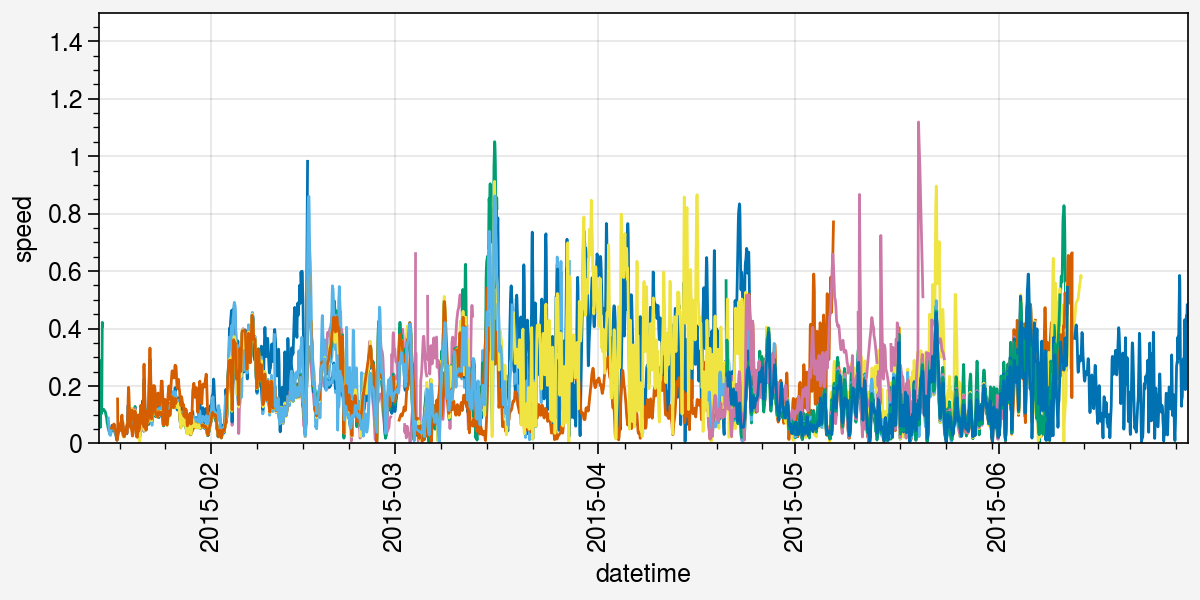

In [134]:
last_date = pd.to_datetime('2015-07-01')
fig, ax = pplt.subplots(width=6, height=3)
for buoy in nice_interp:
    if np.any(nice_interp[buoy].speed[:last_date] > 1):
        print(buoy)
    ax.plot(nice_interp[buoy].speed[:last_date].where(nice_interp[buoy].loc[:last_date, 'qc']==0), lw=1)
ax.format(ylim=(0, 1.5))

SIMBA_2015g
SIMBA_2015a
CALIB_2015b
SIMBA_2015d


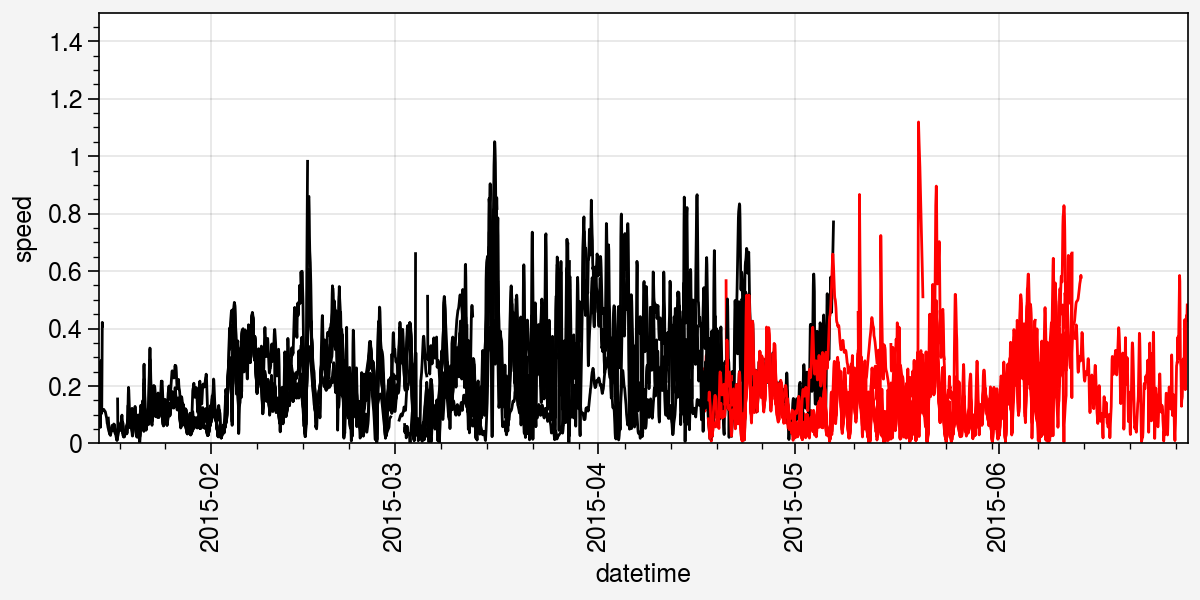

In [136]:
last_date = pd.to_datetime('2015-07-01')
fig, ax = pplt.subplots(width=6, height=3)
for buoy in nice_interp:
    if np.any(nice_interp[buoy].speed[:last_date] > 1):
        print(buoy)
    c = 'r'
    if nice_interp[buoy].index[0] < pd.to_datetime('2015-04-01'):
        c = 'k'
    ax.plot(nice_interp[buoy].speed[:last_date].where(nice_interp[buoy].loc[:last_date, 'qc']==0), lw=1, color=c)
ax.format(ylim=(0, 1.5))

Gray lines are the winter deployments
Gray lines are the winter deployments
Gray lines are the winter deployments
Gray lines are the winter deployments
Gray lines are the winter deployments
Gray lines are the winter deployments
Gray lines are the winter deployments
Gray lines are the winter deployments
Gray lines are the winter deployments
Gray lines are the winter deployments
Gray lines are the winter deployments
Gray lines are the winter deployments
Gray lines are the winter deployments
Gray lines are the winter deployments
Gray lines are the winter deployments
Gray lines are the winter deployments
Gray lines are the winter deployments
Gray lines are the winter deployments
Gray lines are the winter deployments
Gray lines are the winter deployments
Gray lines are the winter deployments
Gray lines are the winter deployments
Gray lines are the winter deployments
Gray lines are the winter deployments
Gray lines are the winter deployments
Gray lines are the winter deployments
Gray lines a

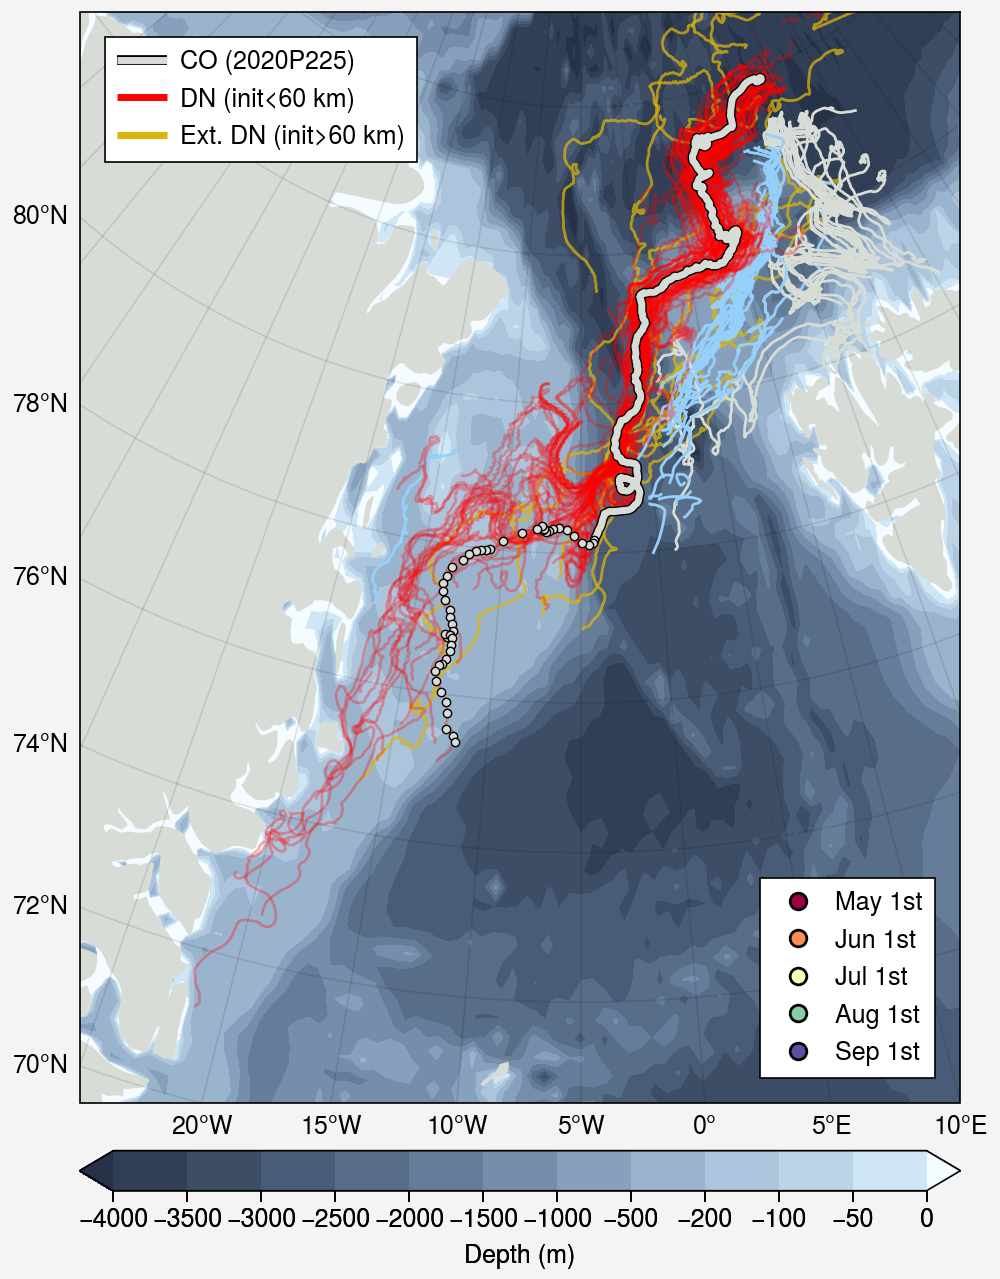

In [212]:
import matplotlib.patheffects as pe
import numpy as np
import os
import pandas as pd
import proplot as pplt
import pyproj
from scipy.interpolate import interp1d
import sys
import warnings
import xarray as xr

warnings.simplefilter("ignore")


#### Load buoy data ####
dataloc = '../archive/data/daily_merged_buoy_data/'
dataloc_hourly = '../archive/data/hourly_merged_buoy_data/'
files = os.listdir(dataloc)
buoy_data = {f.split('.')[0]: pd.read_csv(dataloc + f,
                 parse_dates=True, index_col=0) for f in files if f.split('.')[1] == 'csv'}
buoy_data_hourly = {f.split('.')[0]: pd.read_csv(dataloc_hourly + f,
                 parse_dates=True, index_col=0) for f in files if f.split('.')[1] == 'csv'}


for buoy in buoy_data_hourly:
    buoy_data_hourly[buoy]['speed_wind'] = (buoy_data_hourly[buoy]['u_wind']**2 + \
                                                buoy_data_hourly[buoy]['v_wind']**2)**0.5
    
extended_dn = ['2020P160', '2019P123', '2019P155', '2019P156',
               '2019P157', '2019P182', '2019P127', '2019P128',
                '2019P184']
dn = [b for b in buoy_data if b not in extended_dn]
dn = [b for b in dn if buoy_data[b].latitude.max() < 85]


depth = xr.open_dataset('../archive/data/interpolated_depth.nc')

#### Plot the map #####
pplt.rc['reso'] = 'med'
plot_buoy = '2020P225'

colors = {m: c['color'] for m, c in zip(['May', 'June', 'July', 'August', 'September'],
                                        pplt.Cycle('spectral', N=5))}

fig, ax = pplt.subplots(proj='ortho', proj_kw={'lon_0': -5, 'lat_0': 75}, width=5)
ax.format(latlim=(70, 85), lonlim=(-25,10),  land=True,
          landcolor='light gray', latlabels=True, lonlabels=True)
cbar = ax.contourf(depth.longitude,
                depth.latitude,
                depth.z, levels=[-4000, -3500, -3000, -2500,
                              -2000, -1500, -1000, -500,
                              -200, -100, -50, 0],
                cmap='blues8_r',
                extend='both')

for buoy in extended_dn:
    ax.plot(buoy_data_hourly[buoy].longitude,
           buoy_data_hourly[buoy].latitude, color='gold', lw=1, alpha=0.75, zorder=2)


for buoy in dn:
    buoy_df = buoy_data_hourly[buoy].resample('1H').asfreq()
    ax.plot(buoy_df.longitude,
           buoy_df.latitude, color='r', lw=1, alpha=0.3, zorder=3)

    if buoy == plot_buoy:
        sic = buoy_data[buoy].sea_ice_concentration
        last = sic[sic > 0].index[-1]
        ts_ice = slice('2020-05-01', last)
        ts_water = slice(last + pd.to_timedelta('12H'), '2020-09-01 00:00')
        ax.plot(buoy_data_hourly[buoy].longitude.loc[ts_ice],
                buoy_data_hourly[buoy].latitude.loc[ts_ice],
                color='light gray', lw=2.5, zorder=5,
               path_effects=[pe.Stroke(linewidth=3.5, foreground='k'), pe.Normal()])
        ax.plot(buoy_data_hourly[buoy].longitude.loc[ts_water].resample('12H', offset=0).asfreq(),
                buoy_data_hourly[buoy].latitude.loc[ts_water].resample('12H', offset=0).asfreq(),
                color='light gray', lw=0, zorder=5, marker='.', edgecolor='k', edgewidth=0.5)
        buoy_data_hourly[buoy] = buoy_data_hourly[buoy].loc[ts_ice].copy()
        buoy_data[buoy] = buoy_data[buoy].loc[ts_ice].copy()        

for buoy in nice_interp:
    df = nice_interp[buoy].where(nice_interp[buoy]['qc'] == 0)
    c = 'light blue'
    if nice_interp[buoy].index[0] < pd.to_datetime('2015-04-01'):
        c = 'light gray'
    print('Gray lines are the winter deployments')
    ax.plot(df.longitude,
            df.latitude, color=c, lw=1)

for m, c in zip([5, 6, 7, 8, 9], colors):
    date = pd.to_datetime('2020-' + str(m).zfill(2) + '-01 00:00')
    if date in buoy_data[plot_buoy].index:
        ax.plot(buoy_data[plot_buoy].loc[date, 'longitude'],
                buoy_data[plot_buoy].loc[date, 'latitude'], c=colors[c],
                marker='o', lw=0, edgecolor='k', s=5, zorder=6)

h = [ax.plot([],[], c=colors[c], marker='o', lw=0, edgecolor='k') for c in colors]
l = [c[0:3] + ' 1st' for c in colors]
ax.legend(h, l, ncols=1, loc='lr', pad=1, alpha=1)

h = [ax.plot([],[], c='light gray', lw=2.5,
            path_effects=[pe.Stroke(linewidth=3.5, foreground='k'), pe.Normal()]),
     ax.plot([],[],c='r', lw=2.5), ax.plot([],[], lw=2.5, color='gold')]
     
l = ['CO (' + plot_buoy + ')', 'DN (init<60 km)', 'Ext. DN (init>60 km)']
ax.legend(h, l, ncols=1, loc='ul', pad=1, alpha=1)

        
ax.colorbar(cbar, label='Depth (m)', loc='b')

Do the periods of sub-daily oscillations appear at the location of a change in depth? Depending on how you count it, there's increases in sub-daily variability around 18 May and around 25 May.


Green lines are the winter deployments


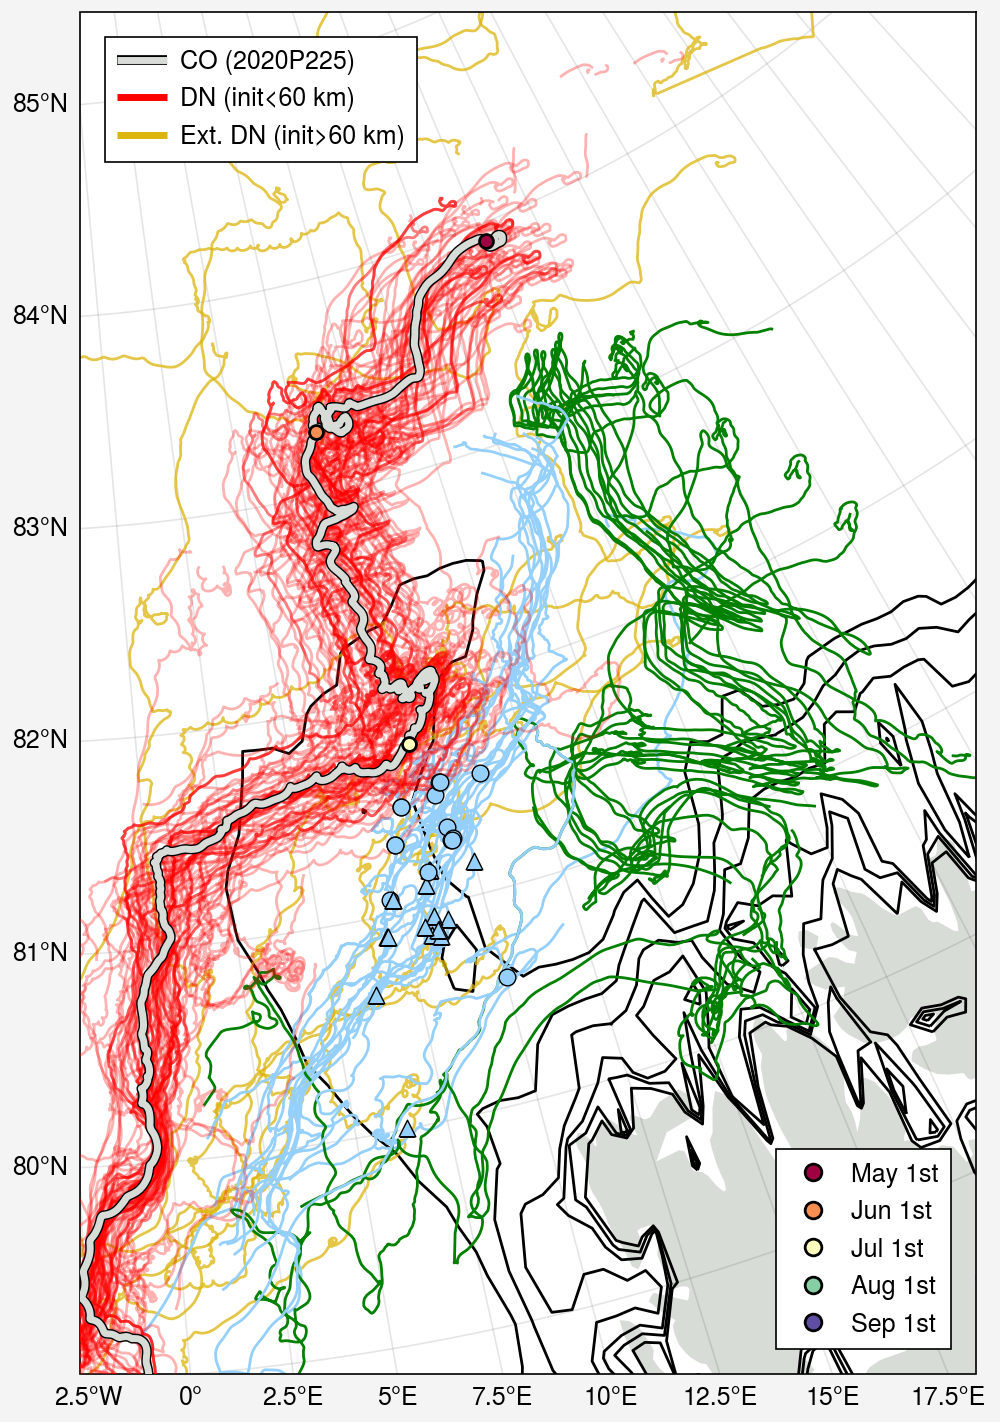

In [146]:
import matplotlib.patheffects as pe
import numpy as np
import os
import pandas as pd
import proplot as pplt
import pyproj
from scipy.interpolate import interp1d
import sys
import warnings
import xarray as xr

warnings.simplefilter("ignore")


#### Load buoy data ####
dataloc = '../archive/data/daily_merged_buoy_data/'
dataloc_hourly = '../archive/data/hourly_merged_buoy_data/'
files = os.listdir(dataloc)
buoy_data = {f.split('.')[0]: pd.read_csv(dataloc + f,
                 parse_dates=True, index_col=0) for f in files if f.split('.')[1] == 'csv'}
buoy_data_hourly = {f.split('.')[0]: pd.read_csv(dataloc_hourly + f,
                 parse_dates=True, index_col=0) for f in files if f.split('.')[1] == 'csv'}


for buoy in buoy_data_hourly:
    buoy_data_hourly[buoy]['speed_wind'] = (buoy_data_hourly[buoy]['u_wind']**2 + \
                                                buoy_data_hourly[buoy]['v_wind']**2)**0.5
    
extended_dn = ['2020P160', '2019P123', '2019P155', '2019P156',
               '2019P157', '2019P182', '2019P127', '2019P128',
                '2019P184']
dn = [b for b in buoy_data if b not in extended_dn]
dn = [b for b in dn if buoy_data[b].latitude.max() < 85]


depth = xr.open_dataset('../archive/data/interpolated_depth.nc')

#### Plot the map #####
pplt.rc['reso'] = 'med'
plot_buoy = '2020P225'

colors = {m: c['color'] for m, c in zip(['May', 'June', 'July', 'August', 'September'],
                                        pplt.Cycle('spectral', N=5))}

fig, ax = pplt.subplots(proj='ortho', proj_kw={'lon_0': -5, 'lat_0': 75}, width=5)
ax.format(latlim=(79, 85), lonlim=(0,20),  land=True,
          landcolor='light gray', latlabels=True, lonlabels=True)
cbar = ax.contour(depth.longitude,
                depth.latitude,
                depth.z, levels=[-1000, -500,
                              -200, -100, -50, 0],
                color='k', lw=1, ls='-')

for buoy in extended_dn:
    ax.plot(buoy_data_hourly[buoy].longitude,
           buoy_data_hourly[buoy].latitude, color='gold', lw=1, alpha=0.75, zorder=2)


for buoy in dn:
    buoy_df = buoy_data_hourly[buoy].resample('1H').asfreq()
    ax.plot(buoy_df.longitude,
           buoy_df.latitude, color='r', lw=1, alpha=0.3, zorder=3)

    if buoy == plot_buoy:
        sic = buoy_data[buoy].sea_ice_concentration
        last = sic[sic > 0].index[-1]
        ts_ice = slice('2020-05-01', last)
        ts_water = slice(last + pd.to_timedelta('12H'), '2020-09-01 00:00')
        ax.plot(buoy_data_hourly[buoy].longitude.loc[ts_ice],
                buoy_data_hourly[buoy].latitude.loc[ts_ice],
                color='light gray', lw=2.5, zorder=5,
               path_effects=[pe.Stroke(linewidth=3.5, foreground='k'), pe.Normal()])
        ax.plot(buoy_data_hourly[buoy].longitude.loc[ts_water].resample('12H', offset=0).asfreq(),
                buoy_data_hourly[buoy].latitude.loc[ts_water].resample('12H', offset=0).asfreq(),
                color='light gray', lw=0, zorder=5, marker='.', edgecolor='k', edgewidth=0.5)
        buoy_data_hourly[buoy] = buoy_data_hourly[buoy].loc[ts_ice].copy()
        buoy_data[buoy] = buoy_data[buoy].loc[ts_ice].copy()        

for buoy in nice_interp:
    df = nice_interp[buoy].where(nice_interp[buoy]['qc'] == 0)
    c = 'light blue'
    if nice_interp[buoy].index[0] < pd.to_datetime('2015-04-01'):
        c = 'g'

    ax.plot(df.longitude,
            df.latitude, color=c, lw=1)
    plot_date = pd.to_datetime('2015-05-18 00:00')
    if plot_date in df.index:
        ax.scatter(df.loc[plot_date, 'longitude'],
                   df.loc[plot_date, 'latitude'], marker='o', color=c, edgecolor='k', edgewidth=0.5, zorder=50)
        
    plot_date = pd.to_datetime('2015-05-25 00:00')
    if plot_date in df.index:
        ax.scatter(df.loc[plot_date, 'longitude'],
                   df.loc[plot_date, 'latitude'], marker='^', color=c, edgecolor='k', edgewidth=0.5, zorder=50)
        
print('Green lines are the winter deployments')
for m, c in zip([5, 6, 7, 8, 9], colors):
    date = pd.to_datetime('2020-' + str(m).zfill(2) + '-01 00:00')
    if date in buoy_data[plot_buoy].index:
        ax.plot(buoy_data[plot_buoy].loc[date, 'longitude'],
                buoy_data[plot_buoy].loc[date, 'latitude'], c=colors[c],
                marker='o', lw=0, edgecolor='k', s=5, zorder=6)

h = [ax.plot([],[], c=colors[c], marker='o', lw=0, edgecolor='k') for c in colors]
l = [c[0:3] + ' 1st' for c in colors]
ax.legend(h, l, ncols=1, loc='lr', pad=1, alpha=1)

h = [ax.plot([],[], c='light gray', lw=2.5,
            path_effects=[pe.Stroke(linewidth=3.5, foreground='k'), pe.Normal()]),
     ax.plot([],[],c='r', lw=2.5), ax.plot([],[], lw=2.5, color='gold')]
     
l = ['CO (' + plot_buoy + ')', 'DN (init<60 km)', 'Ext. DN (init>60 km)']
ax.legend(h, l, ncols=1, loc='ul', pad=1, alpha=1)

        
#ax.colorbar(cbar, label='Depth (m)', loc='b')

In [149]:
import pyproj
g = pyproj.Geod(ellps='WGS84')

In [227]:
# Daily displacement
# For 2019O1 it looks like it's not matching - what gives?
df = buoy_data['2019O1']
dfh = buoy_data_hourly['2019O1']

In [228]:
lon = df.longitude
lat = df.latitude
fwd, inv, dist, = g.inv(lon, lat, lon.shift(1), lat.shift(1))

lon = dfh.longitude
lat = dfh.latitude
fwd, inv, disth, = g.inv(lon, lat, lon.shift(1), lat.shift(1))


In [226]:
df_lon = pd.DataFrame({buoy: buoy_data[buoy]['longitude'] for buoy in buoy_data})
df_lat = pd.DataFrame({buoy: buoy_data[buoy]['latitude'] for buoy in buoy_data})
df_lon.index = df_lon.index - pd.to_timedelta('12H')


In [238]:
dfh

,buoy,longitude,latitude,u,v,speed,depth,u_wind,v_wind,speed_wind,distance
datetime,,,,,,,,,,,
2020-05-01 00:00:00,2019O1,19.20987,83.66718,0.017544,-0.020069,0.026657,-4012.743195,5.064,1.781,5.368059,NaN
2020-05-01 01:00:00,2019O1,19.21456,83.66660,0.015116,-0.014637,0.021041,-4013.252451,4.830,2.140,5.282850,86.801671
2020-05-01 02:00:00,2019O1,19.21895,83.66621,0.013868,-0.010110,0.017162,-4013.471056,4.908,2.372,5.451133,69.446546
2020-05-01 03:00:00,2019O1,19.22289,83.66593,0.014335,-0.004527,0.015032,-4013.551060,4.895,2.489,5.491461,57.747535
2020-05-01 04:00:00,2019O1,19.22756,83.66591,0.018214,0.000906,0.018237,-4013.409361,4.592,2.497,5.226995,57.587958
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-04 08:00:00,2019O1,-0.91142,78.84212,0.053866,-0.352254,0.356349,-2609.779611,3.070,2.011,3.670016,1152.624435
2020-08-04 09:00:00,2019O1,-0.90413,78.82902,0.041281,-0.407072,0.409160,-2580.651912,3.006,1.255,3.257462,1471.107210
2020-08-04 10:00:00,2019O1,-0.89739,78.81531,0.021719,-0.381117,0.381735,-2396.547257,3.251,0.584,3.303037,1537.682052


In [243]:
df['distance'] = dist
dfh['distance'] = disth

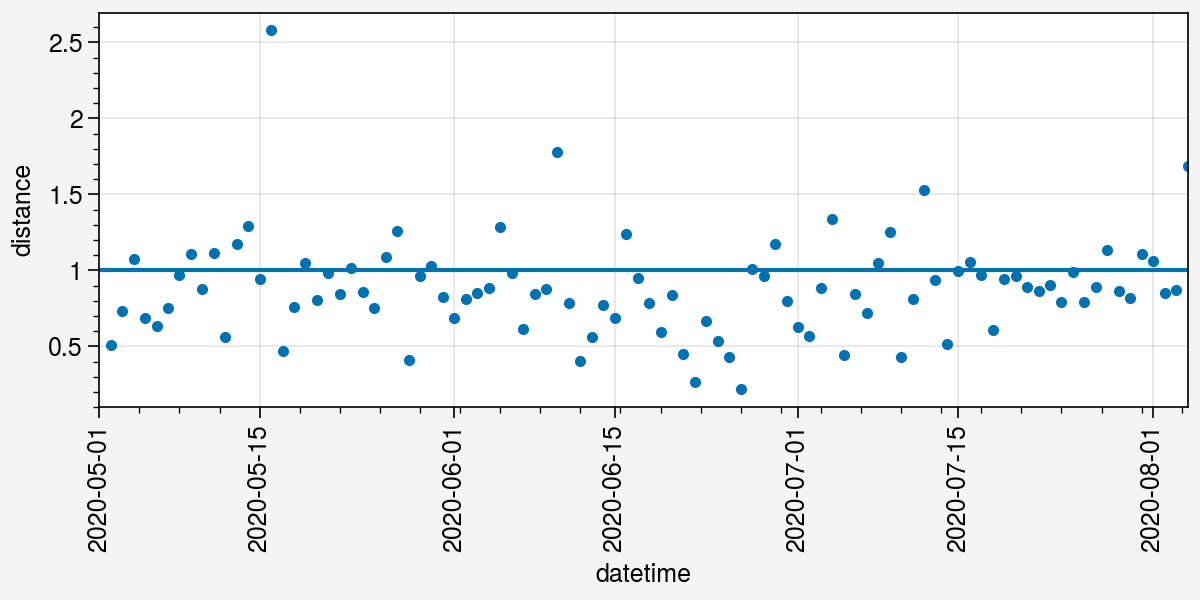

In [240]:
fig, ax = pplt.subplots(width=6, height=3)
ax.plot((df.distance.values/dfh.distance.resample('1D').sum()), marker='.', lw=0)
ax.axhline(1)
#ax.format(ylim=(0, 5))

<AxesSubplot:xlabel='datetime'>

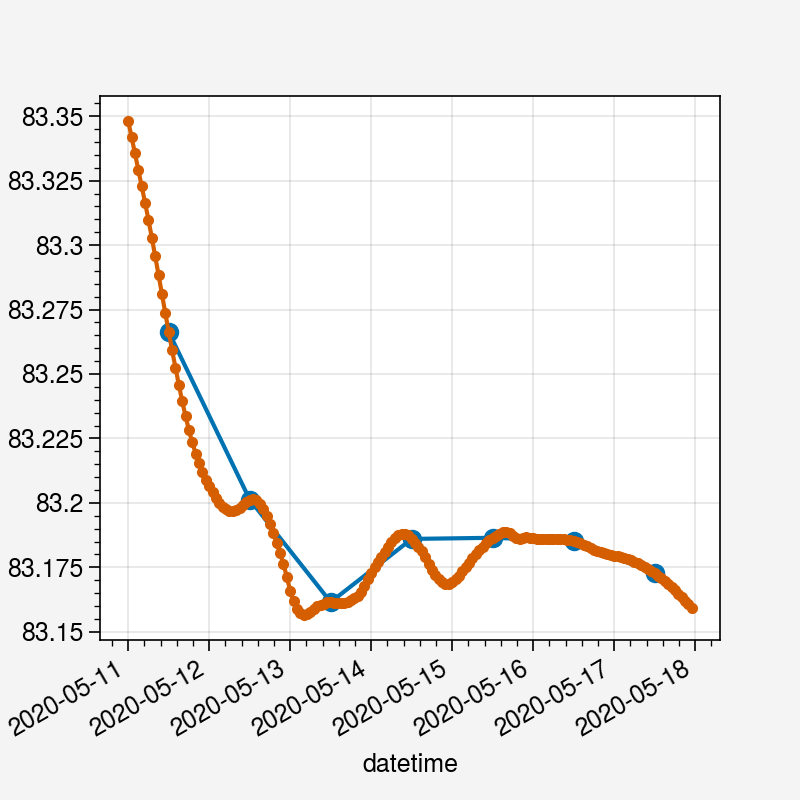

In [242]:
df.latitude.loc[slice('2020-05-11', '2020-05-17')].plot(marker='o')
dfh.latitude.loc[slice('2020-05-11', '2020-05-17')].plot(marker='.')

In [203]:
dfh.distance.resample('1D').sum().loc['2020-05-16'], df.distance.loc['2020-05-16']

(1020.82963643, 2829.533404772591)

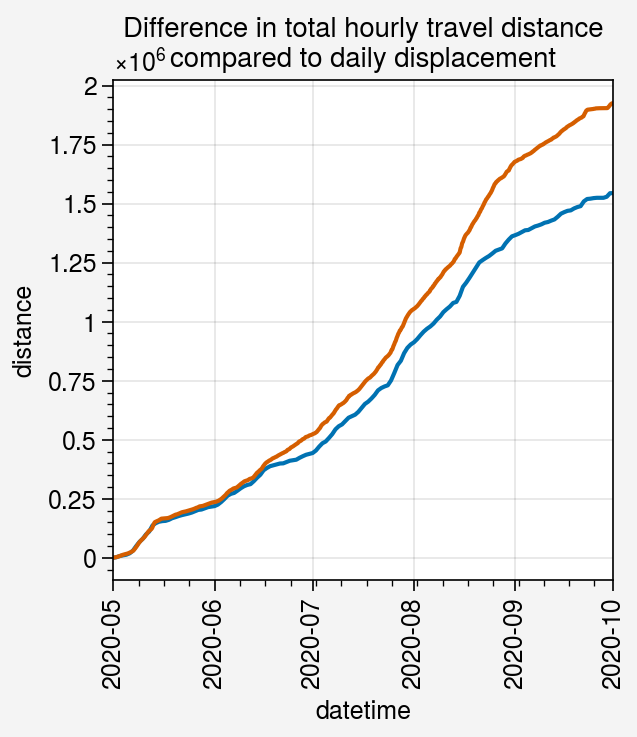

In [184]:
fig, ax = pplt.subplots()
ax.plot(df.index, np.cumsum(df.distance.fillna(0)))
ax.plot(dfh.index, np.cumsum(dfh.distance.fillna(0)))
ax.format(title='Difference in total hourly travel distance\ncompared to daily displacement')

In [177]:
np.cumsum(dist)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])